# Modelos Lineales: Clasificación

### Objetivo: Entrenamiento básico de un modelo de Clasificación Binario

#Institución de regresión logística

 La regresión logística funciona prácticamente igual que la regresión lineal, ya que el modelo calcula una suma ponderada de las características de entrada y luego estima la probabilidad de que el entrenamiento pertenezca a una clase específica en lugar de devolver un resultado particular como lo hace la regresión lineal. Esta es la ecuación:

$$
\hat y= h(\mathbf{\Phi})=\sigma(\mathbf{w}^T\mathbf{\Phi})
$$

donde la función $\sigma()$ es la función sigmoide que permite que la función de hipótesis $h$ resulte en un número entre 0 y 1. La función sigmoide se define de la siguiente manera:
$$
\sigma(z)=\frac{1}{1+e^{-z}}
$$



#La función de costo

¿Cómo generar la función de costo para una clasificación binaria cuando solo contiene dos valores (0 y 1 en este caso)? La idea de evaluar el Modelo Logístico es medir cada diferencia creada por el resultado real y el resultado previsto. La función de costo que utilizamos es
$\renewcommand{\v}[1]{{\mathbf{#1}}}$

$$ J(\v w) = \sum_{n=1}^N [y_n \, ln (\sigma(\mathbf{w}^T\mathbf{\Phi}(\v x_n)))+(1-y_n) \, (1-ln (\sigma(\mathbf{w}^T\mathbf{\Phi}(\v x_n))))] $$
donde $N$ es el número de datos.

El Gradiente es
$$\nabla_w J =\sum_{n=1}^N(\sigma(\mathbf{w}^T\mathbf{\Phi}(\v x_n))-y_n) \Phi_n$$





## Implementación del Código
#### Paso 0: Obtener el repositorio de github (necesitamos algunas de las funciones allí)

El primer paso con todos estos cuadernos de Google Colab será obtener el repositorio de github y el cd en el directorio de cuadernos.

Para ejecutar cosas desde la línea de comando, coloque un ```!``` antes de su código

In [ ]:
#get the github repo
!git clone https://github.com/cjfrodas/samples.git
#cd into the repo so the paths work
import os
os.chdir('/content/')

Cloning into 'samples'...
remote: Enumerating objects: 11, done.
remote: Counting objects: 100% (11/11), done.
remote: Compressing objects: 100% (10/10), done.
remote: Total 11 (delta 1), reused 0 (delta 0), pack-reused 0
Receiving objects: 100% (11/11), 582.28 KiB | 8.44 MiB/s, done.
Resolving deltas: 100% (1/1), done.


#### Pasos 1:  importar paquetes
Importamos los paquetes necesarios.



In [ ]:
#needed packages
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch

import math

#plot parameters
import matplotlib
matplotlib.rcParams['axes.facecolor'] = [0.9,0.9,0.9] #makes a grey background to the axis face
matplotlib.rcParams['axes.labelsize'] = 14 #fontsize in pts
matplotlib.rcParams['axes.titlesize'] = 14
matplotlib.rcParams['xtick.labelsize'] = 12
matplotlib.rcParams['ytick.labelsize'] = 12
matplotlib.rcParams['legend.fontsize'] = 12
matplotlib.rcParams['legend.facecolor'] = 'w'
matplotlib.rcParams['savefig.transparent'] = False

#make default resolution of figures much higher (i.e., High definition)
%config InlineBackend.figure_format = 'retina'

#import some helper functions for our other directory.
import sys
sys.path.insert(1, '/content/samples/')

#### Pasos 2: definir funciones
Definimos la funciones necesarias.



In [ ]:
def design_matrix(x):
    ' matriz de diseño'
    return torch.hstack((torch.ones(x.shape[0],1),x))

In [ ]:
def model (w,phi): # función de predicción propuesta (fn lineal)
    return sigmo(phi @ w)


In [ ]:
def sigmo(x):
    """ Calcula el valor sigmoide de las de entradas
         Parameters:
          x:  valores
        Return value: valor sigmoide
    """
    return 1/(1+torch.exp(-x))


In [ ]:
def loss_cesig(y_pred,y_obs): # funcion de costo: cross entropy con y=sigmoide
    return -(torch.mean(torch.log(y_pred)*y_obs)+torch.mean(torch.log(1-y_pred)*(1-y_obs)))

In [ ]:
def nablaJ(w,phi,y_obs):
    """
    calculo el gradiente de la función de pérdida
    en función de los pesos
    """
    y_pred=model(w,phi)
    dJdf = y_pred-y_obs
    dJdw = torch.mean(phi*dJdf[None,...],1).T
    # dJdw = phi.T @ dJdf / phi.shape[0] # alternativa
    return dJdw

#### Pasos 3: cargar datos para la clasificación
Importamos datos.



In [ ]:
datos=pd.read_csv("/content/samples/weight-height.csv")
print(datos.shape)

(10000, 3)


Hecho una mirada a la estructura de los datos.

In [ ]:
print(datos)

      Gender     Height      Weight
0       Male  73.847017  241.893563
1       Male  68.781904  162.310473
2       Male  74.110105  212.740856
3       Male  71.730978  220.042470
4       Male  69.881796  206.349801
...      ...        ...         ...
9995  Female  66.172652  136.777454
9996  Female  67.067155  170.867906
9997  Female  63.867992  128.475319
9998  Female  69.034243  163.852461
9999  Female  61.944246  113.649103

[10000 rows x 3 columns]


La altura está en pulgadas y el peso en libras. Ahora vamos a ver si hay datos nulos.

In [ ]:
#checking missing values
# X1 is the number of null values in each column
X1 = datos.isnull().sum().to_numpy()
print(X1)

[0 0 0]


No hay datos nulos. Ahora veamos cuántos datos correponden a mujeres y cuántos a hombres. De paso creo dos conjuntos de datos, uno para hombres y otro para mujeres para algún uso posterior.

In [ ]:
#divido los datos por género
X_male = datos.loc[datos['Gender']=="Male"]
X_female = datos.loc[datos['Gender']=="Female"]
print('hombres:',X_male.shape,'mujeres:',X_female.shape)

hombres: (5000, 3) mujeres: (5000, 3)


Hay 5000 datos para hombres y 5000 para mujeres. Pero ¿cómo están todos distribuidos?

In [ ]:
#encuentra muestras con hombres
idx_male = np.where(datos['Gender']=="Male")[0]
#encuentra muestras con mujeres
idx_female = np.where(datos['Gender']=="Female")[0]

print(idx_male)
print(idx_female)

[   0    1    2 ... 4997 4998 4999]
[5000 5001 5002 ... 9997 9998 9999]


Los 5000 primeros son hombres y los 5000 segundos mujeres. Ahora creamos un vector con 5000 ceros y 5000 unos para que nos sirva como salida (target).Los ceros etiquetarán a hombres y los unos a las mujeres.


In [ ]:
Y=np.ones(10000)
Y[0:4999]=0
#print(Y)

Paso la altura a cm y el peso a kg. No es necesario hacerlo.

In [ ]:
# libras a kg y pulgadas a cm --> esto no es necesario
datos['Weight'] = datos['Weight'] * 0.454
datos['Height'] = datos['Height'] * 2.54

print(datos)

      Gender      Height      Weight
0       Male  187.571423  109.819678
1       Male  174.706036   73.688955
2       Male  188.239668   96.584348
3       Male  182.196685   99.899282
4       Male  177.499761   93.682809
...      ...         ...         ...
9995  Female  168.078536   62.096964
9996  Female  170.350573   77.574029
9997  Female  162.224700   58.327795
9998  Female  175.346978   74.389017
9999  Female  157.338385   51.596693

[10000 rows x 3 columns]


Luego armo los datos de entrada. Primero con una sola característica, vamos a elegir altura. También con dos características para luego comparar resultados.

In [ ]:
H = datos['Height']
W = datos['Weight']


#print(H)

#variable donde solo tengo en cuenta la altura
index_number= np.random.permutation(10000)
h1,y1=H[index_number].values.reshape((10000,1)),Y[index_number]
#print(h1)
#print(y1)
h_train , h_val = h1[:8000], h1[8000:]
y_train , y_val = y1[:8000], y1[8000:]

#variable donde tengo en cuenta el peso y la altura
D=datos.drop(['Gender'], axis=1)
F=D.to_numpy()
f1=F[index_number,:]
hw_train , hw_val= f1[:8000,:], f1[8000:,:],



In [ ]:
# Normalizamos los datos
def MinMaxScaler(x):
    return (x-x.min())/(x.max()-x.min())

h_train=MinMaxScaler(h_train)
h_val=MinMaxScaler(h_val)

hw_train = MinMaxScaler(hw_train)
hw_val = MinMaxScaler(hw_val)


Los datos son arreglos de numpy y los queremos convertir en tensores de pytorch.

In [ ]:

h_train =torch.from_numpy(h_train)
h_val =torch.from_numpy(h_val)

hw_train =torch.from_numpy(hw_train)
hw_val =torch.from_numpy(hw_val)

y_train =torch.from_numpy(y_train)
y_val =torch.from_numpy(y_val)

print(type(h_train))

print('h_train, y_train shapes: {},{}'.format(h_train.shape,y_train.shape))
print('h_val, y_val shapes: {},{}'.format(h_val.shape,y_val.shape))
#print('h_test, y_test shapes: {},{}'.format(h_test.shape,y_test.shape))

# guardo los datos para un uso posterior; puede ayudar a evitar problemas si vuelvo a ejecutar una celda
class dat:
    h_train=h_train; hw_train=hw_train; y_train=y_train
    h_val=h_val; hw_val=hw_val; y_val=y_val


<class 'torch.Tensor'>
h_train, y_train shapes: torch.Size([8000, 1]),torch.Size([8000])
h_val, y_val shapes: torch.Size([2000, 1]),torch.Size([2000])


#### Paso 4: entrenamos el modelo

In [ ]:
# para solo altura
x_train=dat.h_train
x_val=dat.h_val

#para altura y peso
#x_train=dat.hw_train
#x_val=dat.hw_val



# Entrenamiento
n_epochs=12000
eta=1.e-1#learning rate
Jtrain=[]; Jval=[]

phi_train=design_matrix(x_train)
phi_val=design_matrix(x_val)

w=torch.randn(phi_train.shape[1]) # inicializacion de los parámetros
#w = w.type(torch.DoubleTensor)
w=w[:,None].type(torch.DoubleTensor)
y_train=dat.y_train[:,None]
y_val=dat.y_val[:,None]



for i in range(n_epochs):

    w=w - eta * nablaJ(w,phi_train,y_train)

    Jtrain+=[loss_cesig(model(w,phi_train),y_train).item()]
    Jval+=[loss_cesig(model(w,phi_val),y_val).item()]
    if i%3000 == 0:
        print(round(Jtrain[i],3),round(Jval[i],3))
        print(w)

0.895 0.923
tensor([[1.2670],
        [0.1007]], dtype=torch.float64)
0.442 0.434
tensor([[ 3.6526],
        [-7.5241]], dtype=torch.float64)
0.402 0.398
tensor([[  5.1430],
        [-10.5557]], dtype=torch.float64)
0.389 0.388
tensor([[  6.0147],
        [-12.3316]], dtype=torch.float64)


#### Paso 5: Evaluamos el modelo

Para evaluar su modelo, necesitaremos las predicciones del modelo en el conjunto de datos de validación.




La salida de model() no me da valores entre 0 y 1, no me da ceros y unos. Defino una función tal que será 1 si la salida de model es mayor o igaual a 0.5 y me da cero si la salida es menor que 0.5.

In [ ]:
def uno_cero(y):
    for i in range(len(y)):
        if y[i] >=0.5 :
            y[i]=1
        if y[i] < 0.5 :
            y[i]=0
    return y

In [ ]:
y_hat = model(w,phi_val)

yhat=uno_cero(y_hat)

Nombro el vector de predicción yhat (es decir, $\hat{y}$) para que coincida con la notación matemática habitual. Pero puedes llamarlo ypred si quieres. Este vector es una etiqueta para cada muestra, por lo que podemos ver un histograma de los resultados o podemos calcular algunas métricas más informativas.

##### a). Tabla de contingencia: Precisión

Para obtener esas métricas más informativas, obtengamos la tabla de contingencia que es:


| | Sí | No|
| ----------- | :----: | :----: |
| **Sí** | Éxitos | Falsas Alarmas|
| **No** | Fracasos | Nulos correctos |

La columna de la izquierda son las predicciones del modelo, mientras que la fila superior son las observaciones (etiquetas verdaderas). Cada lugar en la tabla se llena en base a:
- si tanto el modelo como la observación predicen **Sí** (ambos predicen una etiqueta de 1, que es un acierto o *Verdadero positivo*)
- si el modelo genera **Sí** pero la observación es **No** (modelo=1,obs=0; Falsa alarma o *Falso positivo*)
- si el modelo dice **No** pero la observación dice **Sí** (model=0,obs=1; Fracaso o *Falso Positivo*)
- si el modelo y la observación dicen **No** (model=0,obs=0; Nulos Correctos o *Verdadero Negativo*)

Hemos codificado esto para usted, así que todo lo que necesitamos usar es la función llamada ```get_contingency_table``` de ```gewitter_functions.py```. El script ha sido tomado prestado de un curso de aprendizaje automático dictado por el Centro Europeo.



In [ ]:
from gewitter_functions import get_contingency_table

#El calculador de la tabla de contingencia espera y_true,y_pred

cont_table = get_contingency_table(y_val,yhat)


#the function returns a dictionary (thats what the curly brackets mean) of each entry in the table.
print(cont_table)

{'num_true_positives': 808, 'num_false_positives': 159, 'num_false_negatives': 192, 'num_true_negatives': 841}


Ahora que tenemos la tabla de contingencia, podemos calcular una métrica simple, precisión. Cual es:

$$ Precisión = \frac{Verdaderos Positivos + Verdaderos Negativos}{Suma De Todas Las Categorías} \times{100}$$

para ser breve, hemos creado una función para hacer esto llamada ```get_accuracy```

In [ ]:
from gewitter_functions import get_acc
accuracy = get_acc(cont_table)
print('Accuracy = {}%'.format(np.round(accuracy,0)))

Accuracy = 82.0%


El 83% de precisión es bueno dado que solo usamos la altura como entrada.



##### b). Tabla de contingencia: diagrama de rendimiento

<img src="https://drive.google.com/uc?id=17xbuOMIaBbRf_gaUYSIbfFMBO3i_3vx9" width="400" height="400" class="center" />

Para medir la habilidad del modelo podemos utilizar un diagrama de rendimiento (que se muestra arriba). Se muestran en el diagrama los modelos con mejor rendimiento (arriba a la derecha) y los modelos con peor rendimiento (abajo a la izquierda, arriba a la izquierda o abajo a la derecha).

Para hacer este diagrama necesitamos calcular 2 variables, la Probabilidad de Detección (POD; eje y) y la Tasa de Éxito (SR; eje x), ambas calculadas a partir de la tabla de contingencia.

$$ \mathrm{POD} = \frac{Verdaderos Positivos}{Verdaderos Positivos + Falsos Negativos} $$

$$ \mathrm{SR} = \frac{Verdaderos Positivos}{Verdaderos Positivos + Falsos Positivos} $$

Una ventaja de este diagrama es que podemos obtener el *Índice de Éxito Crítico* (CSI) del mismo diagrama. CSI se formula como:

$$ \mathrm{CSI} = \frac{Verdaderos positivos}{Verdaderos positivos + Falsos positivos + Falsos negativos} $$

Hemos incluido el cálculo de estos parámetros como funciones también ```get_pod```, ```get_sr```, ```csi_from_sr_and_pod```.



In [ ]:
from gewitter_functions import get_pod,get_sr,csi_from_sr_and_pod
pod = get_pod(cont_table)
sr = get_sr(cont_table)
csi = csi_from_sr_and_pod(sr,pod)

print('POD:{}, SR:{}, CSI:{}'.format(np.round(pod,2),np.round(sr,2),np.round(csi,2)))

POD:0.81, SR:0.84, CSI:0.7



Ahora que tenemos nuestros valores calculados, podría ponerlos en una tabla o en el diagrama de rendimiento. La función llamada ```make_performance_diagram``` hace el diagrama de rendimiento y ubicamos nuestro resultado en el mismo.

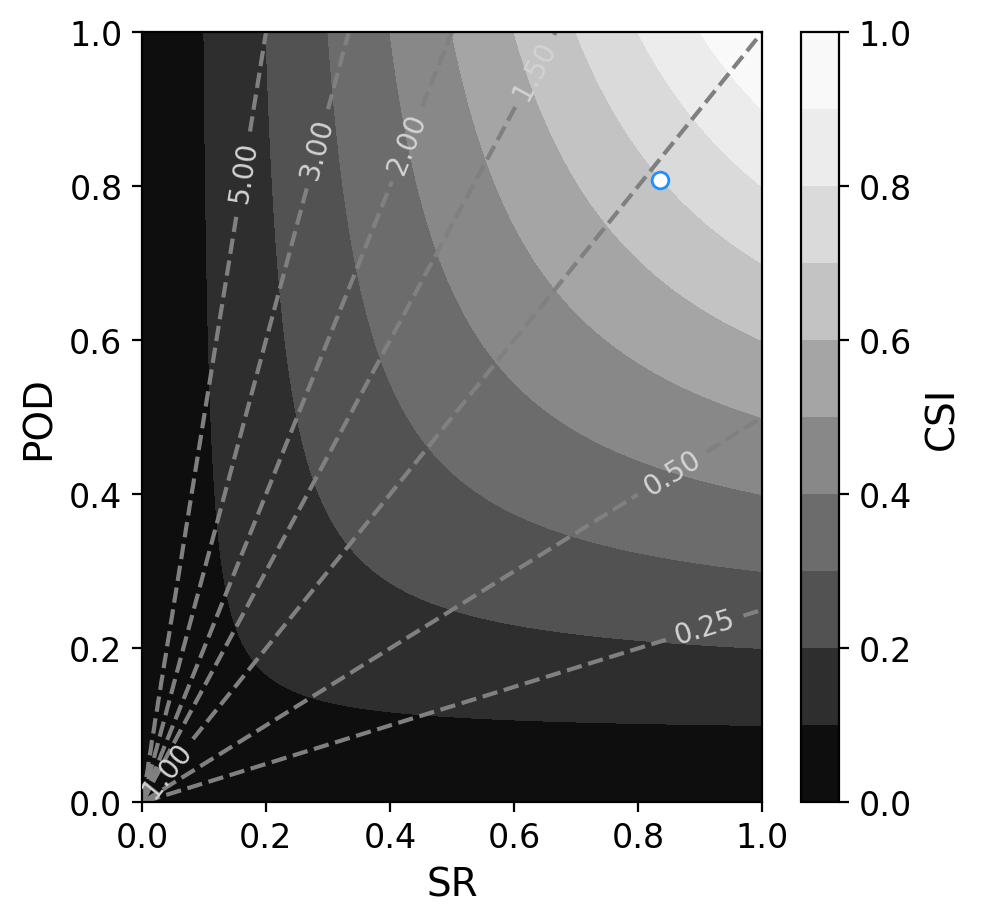

In [ ]:
from gewitter_functions import make_performance_diagram_axis
ax = make_performance_diagram_axis()
ax.plot(sr,pod,'o',color='dodgerblue',markerfacecolor='w');

## <font color='red'> Tareas </font>

* Realice un entrenamiento teniendo en cuenta cuenta solo la altura. Grafique las funciones de pérdida del conjunto de entrenamiento y el de validación. Grafique la estimaciones en 100, en 1.000, en 10.000 y en 100.000 iteraciones. ¿Qué conclusiones saca?
*Realice un entrenamiento teniendo en cuenta cuenta solo el peso. Grafique las funciones de pérdida del conjunto de entrenamiento y el de validación. Grafique la estimaciones en 100, en 1.000, en 10.000 y en 100.000 iteraciones. Compare con los resultados del item anterior ¿Qué conclusiones saca?
* Realice un entrenamiento teniendo en cuenta cuenta el peso y la altura. Repita los cálculos del item anterior y compare los resultados para cuando solo tenía en cuenta la altura o el peso.
* Opcional: Busque alguna base de datos para hacer clasificación binaria (scikit learn tiene varias) y aplique lo desarrollado en el cuaderno. Haga los cambios que considere necesarios.